## Import neccesary libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Loading the data

In [3]:
df = pd.read_csv('de.csv')

# Converting to datetime format
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])

# Extracting time-based features
df['hour'] = df['start'].dt.hour
df['day_of_week'] = df['start'].dt.dayofweek
df['month'] = df['start'].dt.month

In [4]:
# Generate lag features
for lag in range(1,6): # Create lags up to 5 steps back
    df[f'load_t-{lag}'] = df['load'].shift(lag)
# Drop rows with NaN values
df.dropna(inplace=True)

In [5]:
df.head()

,start,end,load,hour,day_of_week,month,load_t-1,load_t-2,load_t-3,load_t-4,load_t-5
5,2015-01-01 01:15:00+00:00,2015-01-01 01:30:00+00:00,40312.0,1,3,1,40618.0,40756.0,41179.0,41518.0,41917.0
6,2015-01-01 01:30:00+00:00,2015-01-01 01:45:00+00:00,39984.0,1,3,1,40312.0,40618.0,40756.0,41179.0,41518.0
7,2015-01-01 01:45:00+00:00,2015-01-01 02:00:00+00:00,39626.0,1,3,1,39984.0,40312.0,40618.0,40756.0,41179.0
8,2015-01-01 02:00:00+00:00,2015-01-01 02:15:00+00:00,39472.0,2,3,1,39626.0,39984.0,40312.0,40618.0,40756.0
9,2015-01-01 02:15:00+00:00,2015-01-01 02:30:00+00:00,39217.0,2,3,1,39472.0,39626.0,39984.0,40312.0,40618.0


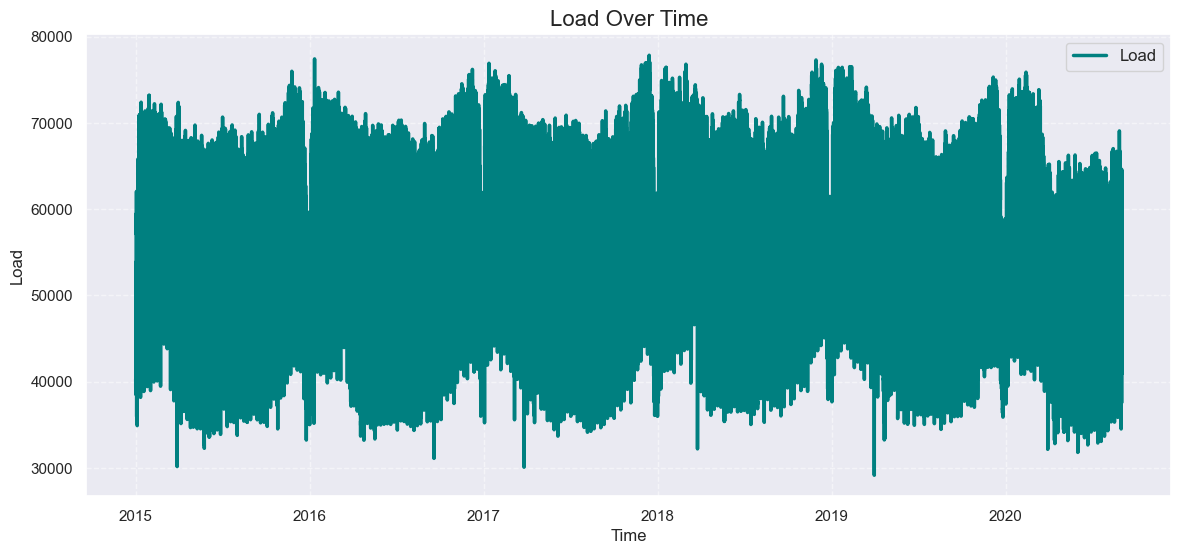

In [6]:
## Visualizing Load Over Time

# Set Seaborn theme
sns.set_theme(style='darkgrid')

# Line plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='start', y='load', label='Load', color='teal', linewidth=2.5)
plt.title('Load Over Time', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Load', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.show()


Graph above shows a clear trend of decreasing consumption in 2020 which is a concequence of COVID-19 pandemics. For this project I am not going to include this period because my goal is to build a predictive model for typical electricity consumption patterns.

In [7]:
# Excluding COVID period

# Define the beginn of the COVID period
start_date = '2020-03-01'

# Filter out the COVID period
df = df[df['start'] < start_date]

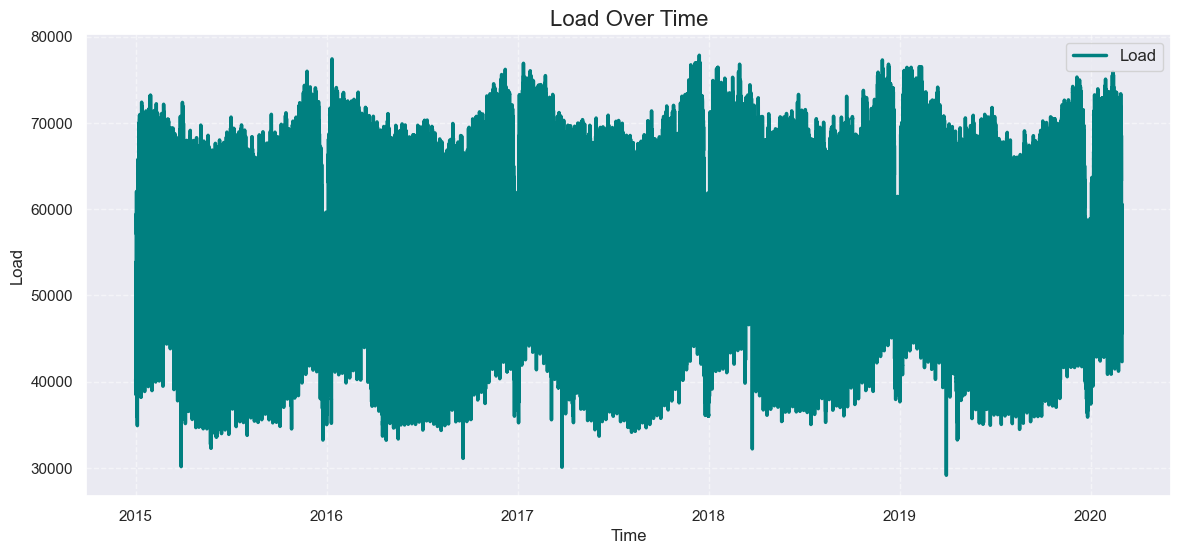

In [8]:
## Visualizing Load Over Time

# Set Seaborn theme
sns.set_theme(style='darkgrid')

# Line plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='start', y='load', label='Load', color='teal', linewidth=2.5)
plt.title('Load Over Time', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Load', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.show()

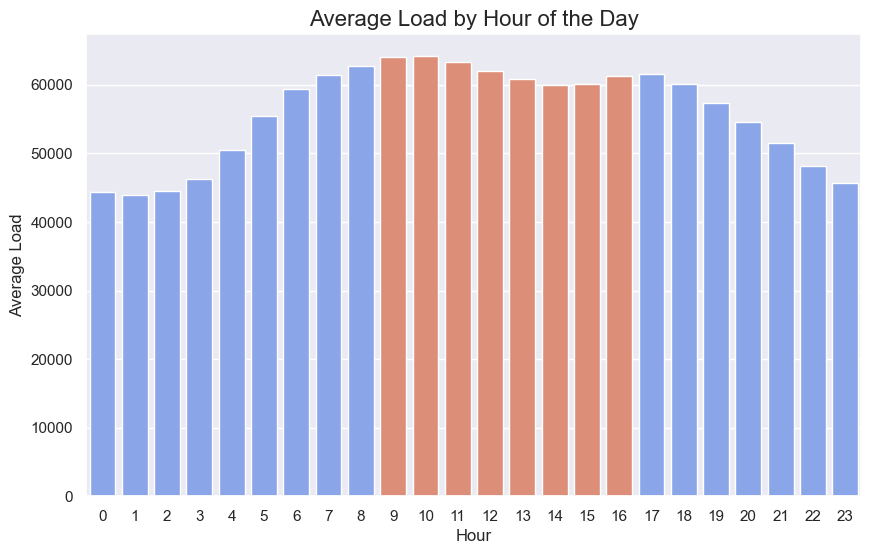

In [9]:
## Daily Patterns

#Calculate hourly averages (group by 'hour' and calculate mean of 'load')
hourly_avg = df.groupby('hour')['load'].mean().reset_index()

# Define working hours (e.g., 9 AM to 17 AM)
working_hours = range(9, 17)

# Create a color map for the working hours
cmap = plt.get_cmap('coolwarm')
colors = [cmap(0.8 if is_working else 0.2) for is_working in hourly_avg['hour'].isin(working_hours)]

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=hourly_avg, x='hour', y='load', hue='hour', palette=mcolors.ListedColormap(colors))

# Add title and labels
plt.title('Average Load by Hour of the Day', fontsize=16)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Average Load', fontsize=12)

# Remove legend since it is not needed for this case
plt.legend([], [], frameon=False)

plt.show()

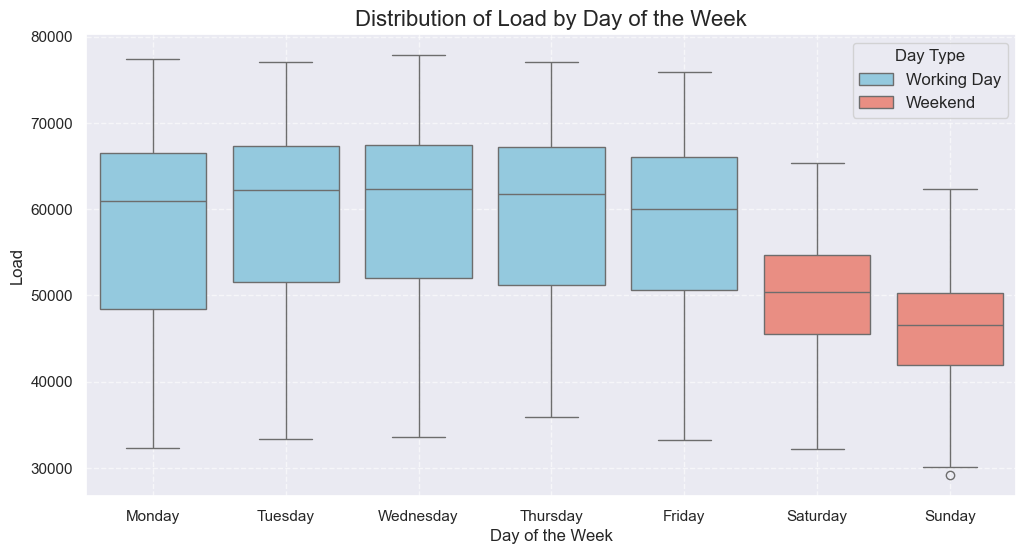

In [10]:
## Boxplot of load by day of the week

# Create a new column to distinguish working days and weekends
df['is_weekend'] = df['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Working Day')

# Map day_of_week numbers to day names
day_name_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['day_name'] = df['day_of_week'].map(day_name_mapping)

# Set up the plot
plt.figure(figsize=(12, 6))

# Create the boxplot with 'hue' set to the new 'is_weekend' column
sns.boxplot(x='day_name', y='load', data=df, hue='is_weekend', palette={'Working Day': 'skyblue', 'Weekend': 'salmon'}, 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Add title and labels
plt.title('Distribution of Load by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Load', fontsize=12)

# Adjust legend and grid
plt.legend(title="Day Type", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

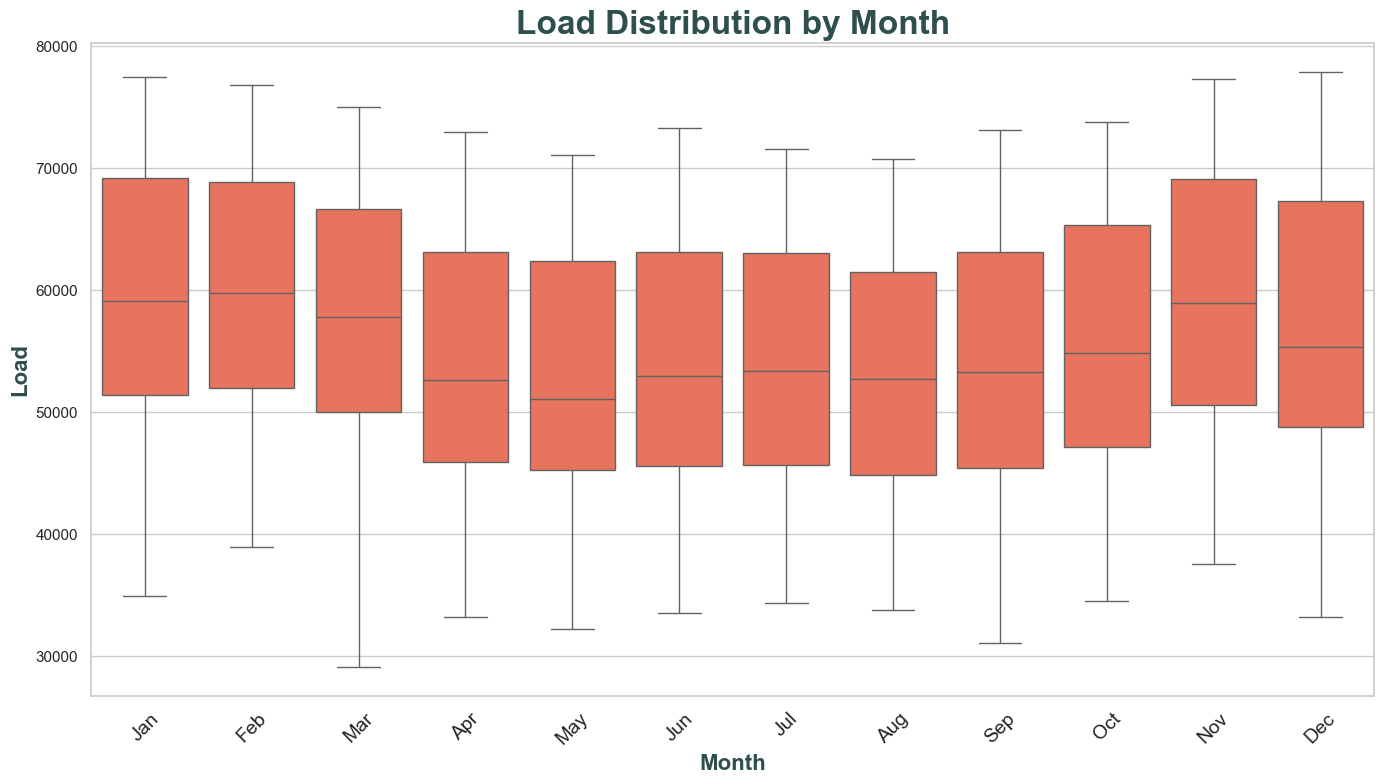

In [11]:
# Load Distribution by Month

# Set the style
sns.set_theme(style="whitegrid", palette="deep")

# Box plot for average load by month
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='month', y='load', color='#FF6347')

# Add labels and title
plt.title('Load Distribution by Month', fontsize=24, weight='bold', color='#2F4F4F')
plt.xlabel('Month', fontsize=16, weight='bold', color='#2F4F4F')
plt.ylabel('Load', fontsize=16, weight='bold', color='#2F4F4F')

# Set x-ticks for months
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14, rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

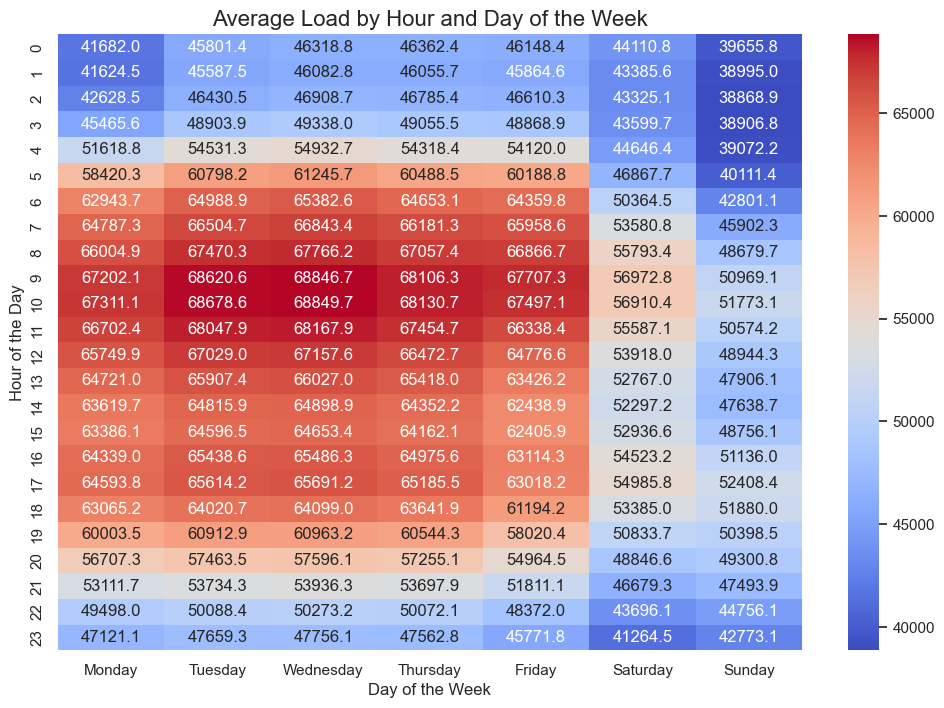

In [12]:
## Heatmap of Average Load by Hour and Day of the Week

# Pivot table for heatmap
heatmap_data = df.pivot_table(index='hour', columns='day_of_week', values='load', aggfunc='mean')

# Rename columns from day_of_week to actual day names
heatmap_data.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='.1f')
plt.title('Average Load by Hour and Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Hour of the Day', fontsize=12)
plt.show()


## Data preparation

In [13]:
# Define features (X) and target (y)
X = df[['hour', 'day_of_week', 'month', 'load_t-1', 'load_t-2', 'load_t-3', 'load_t-4', 'load_t-5']]
y = df['load']

# Split into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # No shuffle for time series data

# Check the shapes of the splits
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(144811, 8) (36203, 8) (144811,) (36203,)


## Training regression model and prediction on test set

In [14]:
# Initialize the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=6, learning_rate=0.05, n_estimators=1000)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model (MSE)
xg_mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {xg_mse}')

Mean Squared Error: 110250.14529600223


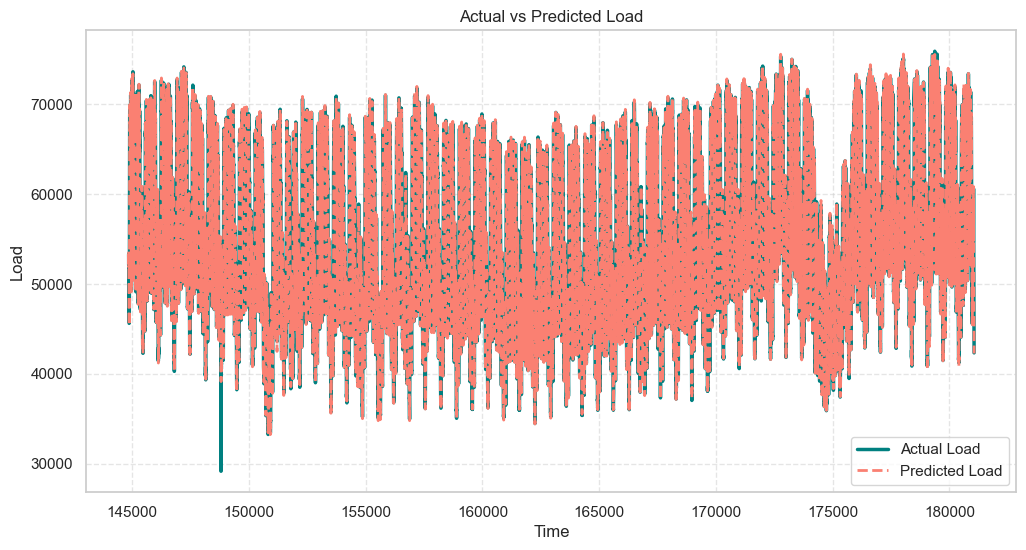

In [16]:
# Plot Actual vs Predicted Load

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual Load', color='teal', linewidth=2.5)
plt.plot(y_test.index, y_pred, label='Predicted Load', color='salmon', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Load')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

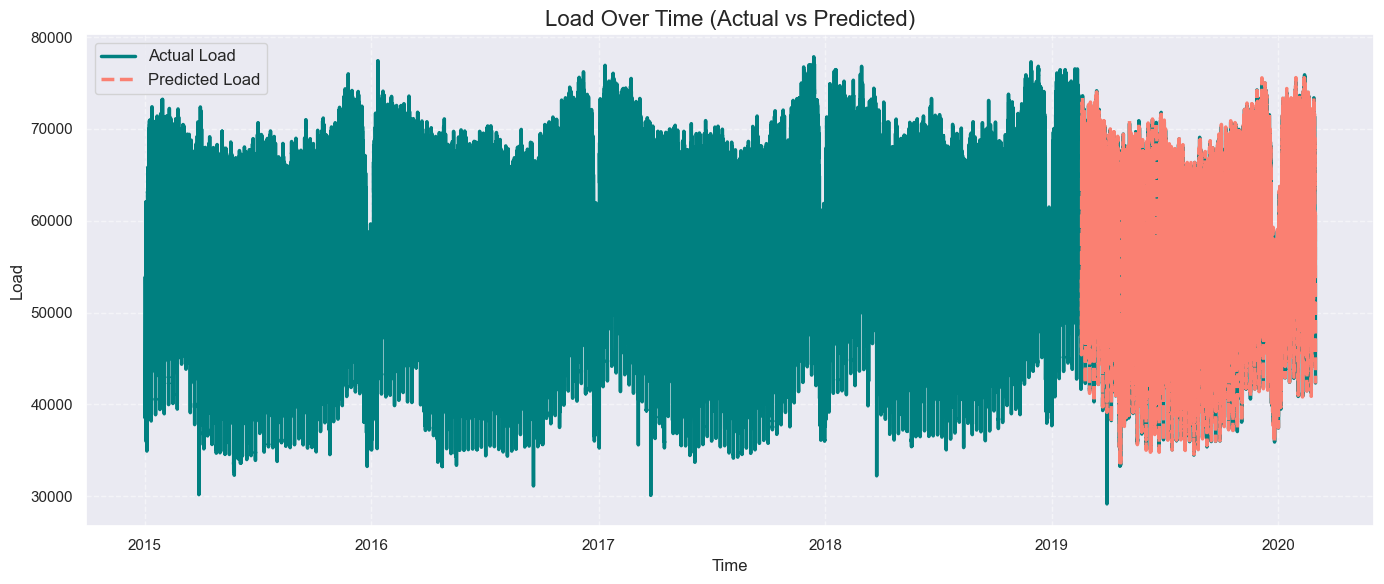

In [17]:
# Plot whole Load Over Time with predicted Values on top of it

# Convert the index of y_test and y_pred to match with the `start` column in the original df
# Align the predicted values with the appropriate time period
y_pred_series = pd.Series(y_pred, index=df['start'].iloc[-len(y_pred):].values)

# Set Seaborn theme
sns.set_theme(style='darkgrid')

# Create a line plot for actual load over time
plt.figure(figsize=(14, 6))

# Plot the actual load
sns.lineplot(data=df, x='start', y='load', label='Actual Load', color='teal', linewidth=2.5)

# Plot the predicted load
sns.lineplot(x=y_pred_series.index, y=y_pred_series.values, label='Predicted Load', color='salmon', linestyle='--', linewidth=2.5)

# Add title and labels
plt.title('Load Over Time (Actual vs Predicted)', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Load', fontsize=12)

# Display the legend
plt.legend(fontsize=12)

# Show grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

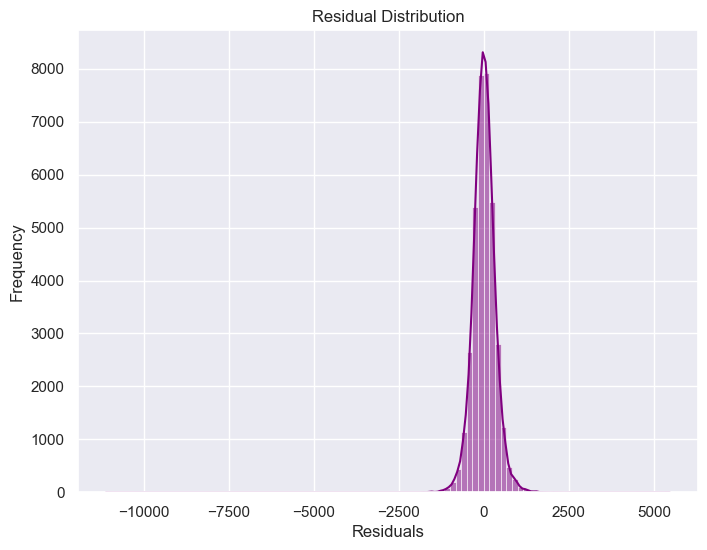

In [18]:
# Residual analysis
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='purple', bins=100)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [19]:
# Try out a simpler model to compare results
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

lr = LinearRegression()
dt = DecisionTreeRegressor(max_depth=6)

lr.fit(X_train, y_train)
dt.fit(X_train, y_train)

lr_mse = mean_squared_error(y_test, lr.predict(X_test))
dt_mse = mean_squared_error(y_test, dt.predict(X_test))

print(f'Linear Regression MSE: {lr_mse:.2f}')
print(f'Decision Tree MSE: {dt_mse:.2f}')
print(f'XGBoost MSE: {xg_mse:.2f}')

Linear Regression MSE: 173135.03
Decision Tree MSE: 395889.83
XGBoost MSE: 110250.15
